In [1]:
import numpy as np
import collections
from torch.utils import data

import sys
sys.path.append('.')
sys.path.append('../')

from einops import rearrange

import torch
import torch.nn as nn
from torch.nn import functional as FeatureAlphaDropout
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from scipy import io as scipyio
import skimage
import skvideo.io

import os
import glob
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"
sys.path.append("neuroformer")

In [2]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [3]:
from utils import set_seed
set_seed(25)

In [4]:
# R3D: (3 x T x H x W)

from SpikeVidUtils import image_dataset

stim_folder = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli"
im_path = ['/Combined Stimuli 3-grating.tif',
           '/Combined Stimuli 3-Movie2.tif',
           '/Combined Stimuli 3-Movie3.tif']

train_path = "/content/stimulus"
train_path = "/Users/antonis/Downloads/OneCombo3/stimuli"
video_stack = [skimage.io.imread(stim_folder + vid) for vid in im_path]
print(glob.glob(train_path + '/*.tif'))
video_stack = np.concatenate(video_stack, axis=0)

# video_stack = skimage.io.imread("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli/Combined Stimuli 3-grating.tif")
# video_stack = image_dataset(video_stack)
# video_stack = video_stack[::3]  # convert from 60 to 20 fps
# video_stack = video_stack.view(1, video_stack.shape[0], video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])

video_stack = image_dataset(video_stack)
video_stack = video_stack[::3]  # convert from 60 to 20 fps
video_stack = video_stack.view(3, video_stack.shape[0] // 3, video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])
# video_stack = video_stack.transpose(-1, -2)

# rearrange(video_stack[0, 0:2].transpose(0,1), 'c t (h p1) (w p2) -> (t h w) (p1 p2 c)', p1=16, p2=16).shape

[]
im_sack size: torch.Size([5760, 1, 64, 112])


In [5]:
video_stack.shape

torch.Size([3, 640, 1, 64, 112])

In [6]:
plt.figure()
plt.imshow(video_stack[0, 1, 0].permute(0, 1))
plt.figure()
plt.imshow(video_stack[1, 1, 0].permute(0, 1))
plt.figure()
plt.imshow(video_stack[2, 1, 0].permute(0, 1))

In [87]:
# spike_path = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/neural/NatureMoviePart1-A" # "code/data/SImIm/simNeu_3D_WithNorm__Combo3.mat" 
from SpikeVidUtils import trial_df_combo3

spike_data = scipyio.loadmat("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/spiketrain.mat")
spike_data = np.squeeze(spike_data['spiketrain'].T, axis=-1)
spike_data = [trial_df_combo3(spike_data, n_stim) for n_stim in range(3)]
spike_data = pd.concat(spike_data, axis=0)

spike_data['Trial'] = spike_data['Trial'] + 1
spike_data['Time'] = spike_data['Time'] * 0.0751
spike_data = spike_data[(spike_data['Time'] > 0) & (spike_data['Time'] <= 32)]

# vid_duration = [len(vid) * 1/20 for vid in vid_list]

df = spike_data
del spike_data

In [88]:
# df_sim = pd.read_csv("data/full_sim__model_weighted_shuffle_decay_True_perceiver_2.0_dt_0.05_eos_8_8_256.csv").iloc[1:, 1:].reset_index(drop=True)
# df_sim = df_sim[df_sim['ID'] <= 164]
# df_sim['Trial'] = df_sim['Trial'] + df['Trial'].max()
# df = pd.concat([df, df_sim], axis=0)

In [89]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
window = 0.5
dt = 0.05

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
# df['Interval_dt'] = make_intervals(df, dt)
# df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(3)
df = df.reset_index(drop=True)

In [90]:
# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
dt_range = int(window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)]
df['Time'] = df['Time'].round(3)

In [91]:
# df.groupby(['Interval', 'Trial']).size().plot.bar()
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
# df.groupby(['Interval', 'Trial']).size().nlargest(100)

In [92]:
from SpikeVidUtils import SpikeTimeVidData

## qv-vae feats
# frames = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_code_feats-24-05-4x4x4.pt").numpy() + 2
# frame_feats = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_embed_feats-24-05-4x4x4.pt").numpy()
# frame_block_size = frames.shape[-1] - 1

## resnet3d feats
frame_feats = video_stack.transpose(1, 2)

frame_block_size = 560
prev_id_block_size = 52
id_block_size = 52   # 95
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
# frames = frames + [*id_stoi.keys()][-1] 
neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
# pixels = sorted(np.unique(frames).tolist())
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))

0.5

In [93]:
# train_len = round(len(df)*(4/5))
# test_len = round(len(df) - train_len)

# train_data = df[:train_len]
# test_data = df[train_len:train_len + test_len].reset_index().drop(['index'], axis=1)

n = []
for n_stim in range(df['Trial'].max() // 20):
    n_trial = [3, 15, 5, 18]
    for n_trial in n_trial:
        trial = (n_stim + 1) * 20 - n_trial
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

In [94]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
# dataset = SpikeTimeVidData(df, frames, frame_feats, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos)
# single_batch = SpikeTimeVidData(df[df['Trial'].isin([5])], None, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats)
small_dataset = SpikeTimeVidData2(small_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)


print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

Length: 20449 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 5163 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 393 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
train: 2941, test: 729


In [95]:
iterable = iter(test_dataset)

In [96]:
x, y = next(iterable)

In [97]:
x['id_prev'][:len(x['id_prev']) - x['pad']]

tensor([165, 166, 167, 167, 167, 167, 167, 167, 167, 167, 167])

In [98]:
x['id'][:len(x['id']) - x['pad']]

tensor([165, 150,  47,  57,  23, 149,  13, 157, 156, 112,  26])

In [99]:
y['id'][:len(y['id']) - x['pad']]

tensor([150,  47,  57,  23, 149,  13, 157, 156, 112,  26, 166])

In [100]:
y['dt'][:len(y['id']) - x['pad']]

tensor([ 1,  3,  3,  4,  5,  6,  7,  8,  8,  9, 10])

In [101]:
x['id'].size()

torch.Size([52])

In [102]:
x['id'].size() == x['id_prev'].size()

True

In [103]:
x['id_prev'].size()

torch.Size([52])

In [104]:
def get_class_weights(dataset):
  dt = []
  id = []
  for x, y in dataset:
    id.extend([stoi['SOS']] + y['id'][:len(y['id']) - x['pad']].flatten().tolist() + [stoi['PAD']]) # -1 in pad to include PAD token
    dt.extend([stoi_dt[0]] + y['dt'][:len(y['dt']) - x['pad']].flatten().tolist() + [dataset.dt_max]) # -1 in pad to include PAD token

  id = pd.DataFrame(id)
  dt = pd.DataFrame(dt)

  id_freq = id.groupby([0]).size()
  dt_freq = dt.groupby([0]).size()

  id_ones = np.ones(dataset.id_population_size)
  dt_ones = np.ones(dataset.dt_population_size)

  id_ones[id_freq.index] = (1 / id_freq) * id_freq.max() / id_freq.max()
  dt_ones[dt_freq.index] = (1 / dt_freq) * dt_freq.max() / dt_freq.max()
  
  class_freq = dict()
  class_freq['id'] = torch.tensor(id_ones, dtype=torch.float32)
  class_freq['dt'] = torch.tensor(dt_ones, dtype=torch.float32)
  
  return class_freq 

class_weights = get_class_weights(train_dataset)

In [105]:
from model_neuroformer import GPT, GPTConfig, neuralGPTConfig, Decoder
# initialize config class and model (holds hyperparameters)
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        sparse_mask=True, p_sparse=0.25,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=class_weights,
                        pretrain=False,
                        n_state_layers=6, n_state_history_layers=6, n_stimulus_layers=6,
                        n_layer=8, n_head=8, n_embd=256,
                        temp_emb=True, pos_emb= True,
                        id_drop=0.2, im_drop=0.2)
model = GPT(mconf)
# model.load_state_dict(torch.load("/home/antonis/projects/slab/git/neuroformer/models/neuroformer:False_perceiver_2.0_dt:0.05_eos_(4, 4, 8)_8_256.pt", map_location='cpu'))

02/04/2022 15:56:31 - INFO - model_neuroformer -   number of parameters: 1.452416e+07


In [106]:
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_8_4_256.pt"))

In [107]:
# loader = DataLoader(small_dataset, shuffle=False, pin_memory=False,
#                                   batch_size=1, num_workers=1)
# x, y = next(iter(loader))
# model = model.to('cpu')

# preds, features, loss = model(x, y)

In [108]:
tsor = torch.randint(1, 10, (1, 3, 4, 100), dtype=torch.float)

In [109]:
tsor[0, 1, 1].mean()

tensor(5.0200)

In [110]:
import torch.nn.functional as F

tsor_norm = F.normalize(tsor, dim=-1)

In [111]:
tsor_norm[0, 0, 1].mean()

tensor(0.0869)

In [112]:
from trainer import Trainer, TrainerConfig
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-01-21-14:18-e:19-b:239-l:4-h:2-ne:512-higher_order.pt"))
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-14-21-23:44-e:17-b:650-l:8-h:4-ne:256-higher_order.pt"))


layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)
max_epochs = 800
batch_size = 32 * 6
shuffle = True
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=8e-5, 
                      num_workers=4, lr_decay=True, patience=3, warmup_tokens=3e5, 
                      decay_weights=True, shuffle=shuffle,
                      final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                      clip_norm=8.0, grad_norm_clip=2.0,
                      dataset='higher_order', mode='predict',
                      block_size=train_dataset.block_size,
                      id_block_size=train_dataset.id_block_size,
                      show_grads=False, plot_raster=False,
                      ckpt_path=f"/home/antonis/projects/slab/git/neuroformer/models/neuroformer_norm_weighted:dt_:{shuffle}_perceiver_2.0_{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt")
# f"/home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:{shuffle}_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.pt")

trainer = Trainer(model, train_dataset, test_dataset, tconf, mconf)
trainer.train()  

epoch 1  id_train: 2.45563  time_train: 1.16282  total_loss: 3.61845 lr 3.993600e-05: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]
02/04/2022 15:56:41 - INFO - trainer -   id_test: 2.37372    time_test: 1.14084  total_loss: 3.51456
02/04/2022 15:56:42 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/neuroformer_norm_weighted:dt_:True_perceiver_2.0_0.05_(6, 6, 6)_8_256.pt
epoch 2  id_train: 2.36140  time_train: 1.15804  total_loss: 3.51944 lr 8.000000e-05: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]
02/04/2022 15:56:51 - INFO - trainer -   id_test: 2.28808    time_test: 1.12308  total_loss: 3.41116
02/04/2022 15:56:51 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/neuroformer_norm_weighted:dt_:True_perceiver_2.0_0.05_(6, 6, 6)_8_256.pt
epoch 3  id_train: 2.24504  time_train: 1.11297  total_loss: 3.35801 lr 7.999968e-05: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]
02/04/2022 15:57:01 - INFO - trainer -   id_test: 2.

KeyboardInterrupt: 

In [ ]:
loader = DataLoader(train_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)                   

In [ ]:
iterable = iter(train_dataset)

In [ ]:
x, y = next(iterable)

In [ ]:
stoi_dt

In [ ]:
print(x['interval'], x['trial'])

In [ ]:
df

In [ ]:
x['id_prev']

In [ ]:
x['id'][..., :len(x['id']) - x['pad']]

In [ ]:
y['id'][..., :len(y['id']) - x['pad']]

In [ ]:
y['dt'][..., :len(x['id']) - x['pad']]

In [ ]:
dt_int = float(x['interval'])
train_data[(train_data['Interval'].isin([dt_int - 0.5, dt_int])) & (train_data['Trial'] == x['trial'])]

In [ ]:
x['interval']

In [ ]:
x['trial'].shape

In [ ]:
x['id']

In [ ]:
x['id_prev']

In [ ]:
model

In [ ]:
def return_att(att_mod):
    return att_mod.att.shape

return_att(model.neural_visual_transformer.neural_state_block[0].attn)

In [ ]:
x['pad']

In [ ]:
(torch.sum(model.neural_visual_transformer.neural_state_block[0].attn.att, axis=1) / 8).shape

In [164]:
""" Predict using TEST dataset """

from utils import predict_raster, predict_raster_resnet, predict_raster_enc_dec, predict_raster_recursive, predict_beam_search, predict_raster_recursive_time, predict_raster_recursive_time_auto, predict_beam_search_time, predict_raster_hungarian
from utils import set_plot_params
set_plot_params()
%matplotlib inline

loader = DataLoader(test_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)

# device = torch.cuda.current_device()
# model = model.to(device)
model.load_state_dict(torch.load("/home/antonis/projects/slab/git/neuroformer/models/neuroformer_norm_weighted:dt_:True_perceiver_2.0_0.05_(6, 6, 6)_8_256.pt"))

""" 

To predict only neurons we pass <frame_end> so we see predictions only for Neurons 
If you want to also see frame_tokens, just pass <frame_end=0>

NOTE: 512 ID is the <end-of-sequence-id>. Right now, makes no difference if I include
it in loss, here it is included in loss and predictions.

"""
# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size, 
#                                                                     get_dt=True)

# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size,
#                                                                     get_dt=True)

# true, predicted = predict_raster(model, loader)

# true, predicted = predict_beam_search(model, loader, stoi, frame_end=0)
# true, predicted, true_timing = predict_raster_recursive(model, loader, stoi, sample=True, top_p=0.95, gpu=True, frame_end=0)
results = predict_raster_recursive_time_auto(model, loader, window, stoi, itos_dt, sample=True, top_p=0.85, top_p_t=0.85, temp=1.0, temp_t=1, frame_end=0, get_dt=True, gpu=False)

# true, predicted = predict_raster_hungarian(model, loader)
# true, predicted = predict_raster(model, loader, gpu=True)

# true_df = pd.DataFrame(true.numpy())
# predicted_df = pd.DataFrame(predicted.numpy())
# print(len(true_df[true_df[0] == 512]), len(predicted_df[predicted_df[0] == 512])) 

100%|██████████| 729/729 [02:06<00:00,  5.75it/s]


In [147]:
# results = predict_raster_recursive_time_auto(model, loader, window, stoi, itos_dt, sample=True, top_p=0.95, top_p_t=0.95, frame_end=0, get_dt=True, gpu=False)

pred_keys = ['pred', 'time_pred', 'trial', 'interval']
predicted_dict = {k: results[k] for k in results if k in pred_keys}
df_pred = pd.DataFrame(predicted_dict)
df_pred.rename({'pred':'ID', 'time_pred':'dt', 'trial':'Trial'}, axis=1, inplace=True)
df_pred['Time'] = df_pred['dt'] + df_pred['interval'] - 0.5
# df_true['time'] = df_true['dt'] + df_true['interval'] - 0.5

In [148]:
true_keys = ['true', 'time']
true_dict = {k: results[k] for k in results if k in true_keys}
df_true = pd.DataFrame(true_dict)
df_true.rename({'true':'ID', 'time':'dt'}, axis=1, inplace=True)

In [149]:
# # predicted_timing = [itos_dt[int(dt)] for dt in predicted_timing]
# # df_pred = pd.DataFrame({'True':true, 'Predicted':predicted, 'Time':true_timing, 'Predicted_Time':predicted_timing})    # Time':test_data['Time']})
# df_pred.to_csv(f"/content/drive/MyDrive/slab/predictions/OneCombo3/model_weighted_shuffle:{shuffle}_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.csv")

In [150]:
# df_sim = pd.read_csv("/home/antonis/projects/slab/git/neuroformer/data/full_sim__model_weighted_shuffle_decay_True_perceiver_2.0_dt_0.05_eos_8_8_256.csv").iloc[:,1:].reset_index(drop=True)

In [151]:
print(len(df_true), len(df_pred))

5893 5972


In [152]:
df_pred[:50]

,ID,dt,Trial,interval,Time
0,0,0.00,0,0.0,-0.50
1,24,0.05,2,0.5,0.05
2,26,0.15,2,0.5,0.15
3,84,0.50,2,0.5,0.50
4,166,0.50,2,0.5,0.50
5,13,0.05,2,1.0,0.55
6,162,0.05,2,1.0,0.55
7,12,0.20,2,1.0,0.70
8,154,0.25,2,1.0,0.75
9,49,0.25,2,1.0,0.75


In [153]:
df_true

,ID,dt
0,0,0.00
1,150,0.05
2,47,0.15
3,57,0.15
4,23,0.20
...,...,...
5888,93,0.10
5889,4,0.15
5890,93,0.15
5891,85,0.30


In [154]:
train_data[:30]

,Time,ID,Trial,Interval
0,0.031,16,1,0.5
1,0.055,156,1,0.5
2,0.143,105,1,0.5
3,0.161,109,1,0.5
4,0.198,72,1,0.5
5,0.204,162,1,0.5
6,0.213,71,1,0.5
7,0.222,66,1,0.5
8,0.240,71,1,0.5
9,0.288,44,1,0.5


In [155]:
df_true[df_true['dt'] == 0.5]

,ID,dt
11,166,0.5
26,166,0.5
31,150,0.5
32,166,0.5
38,166,0.5
...,...,...
5875,166,0.5
5883,93,0.5
5884,166,0.5
5886,166,0.5


<AxesSubplot:xlabel='dt'>

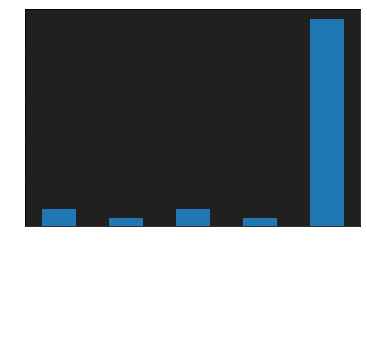

In [156]:
df_pred[df_pred['ID'] == 166][:30].groupby('dt').size().plot.bar()

In [157]:
test_data[:40]

,Time,ID,Trial,Interval
0,0.074,150,2,0.5
1,0.138,47,2,0.5
2,0.153,57,2,0.5
3,0.212,23,2,0.5
4,0.231,149,2,0.5
5,0.324,13,2,0.5
6,0.345,157,2,0.5
7,0.389,156,2,0.5
8,0.393,112,2,0.5
9,0.429,26,2,0.5


In [158]:
freq_dt_true = df_true.groupby(['dt']).size()


In [159]:
df_pred[30:2 * 30]

,ID,dt,Trial,interval,Time
30,104,0.40,2,3.0,2.90
31,40,0.45,2,3.0,2.95
32,109,0.50,2,3.0,3.00
33,166,0.50,2,3.0,3.00
34,26,0.00,2,3.5,3.00
35,49,0.00,2,3.5,3.00
36,166,0.05,2,3.5,3.05
37,119,0.05,2,3.5,3.05
38,111,0.05,2,3.5,3.05
39,135,0.05,2,3.5,3.05


In [160]:
df_true[:30]

,ID,dt
0,0,0.00
1,150,0.05
2,47,0.15
3,57,0.15
4,23,0.20
5,149,0.25
6,13,0.30
7,157,0.35
8,156,0.40
9,112,0.40


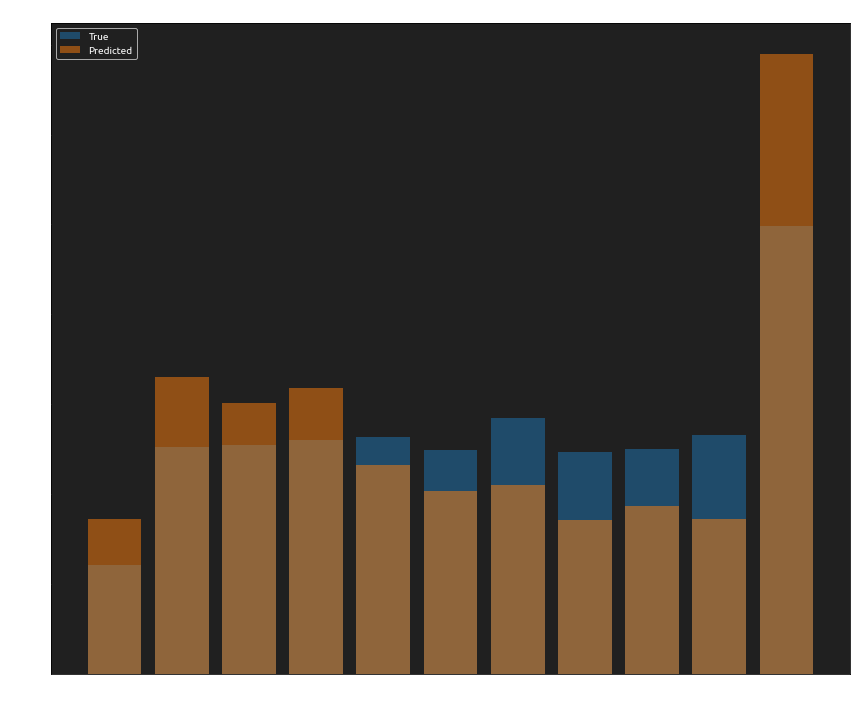

In [161]:
# df_dt = [y['dt'][:len(y['dt']) - (x['pad'])] for x, y in test_dataset]
plt.figure(figsize=(12,10))

# df_dt = df_true['time']
freq_dt_true = df_true.groupby(['dt']).size()
# freq_dt_true = df_sim.groupby(['dt']).size()
plt.bar(np.arange(len(freq_dt_true.index)), freq_dt_true, alpha=0.5, label='True')


# df_dt_pred = df_pred['time_pred']
freq_dt_pred = df_pred.groupby(['dt']).size()
plt.bar(np.arange(len(freq_dt_pred.index)), freq_dt_pred, alpha=0.5, label='Predicted')


# plt.xticks(ticks=pd.to_numeric(freq_dt_pred.index)labels=pd.to_numeric(freq_dt_pred.index))
plt.title('dt Interval Groups')
plt.xlabel('dt Group (n x 0.05s)')
plt.ylabel('Count (N)')

plt.legend()

plt.tight_layout()
# plt.savefig("dt_interval_dist.png", dpi=300)


In [162]:
print(len(df_pred), len(df_true))

5972 5893


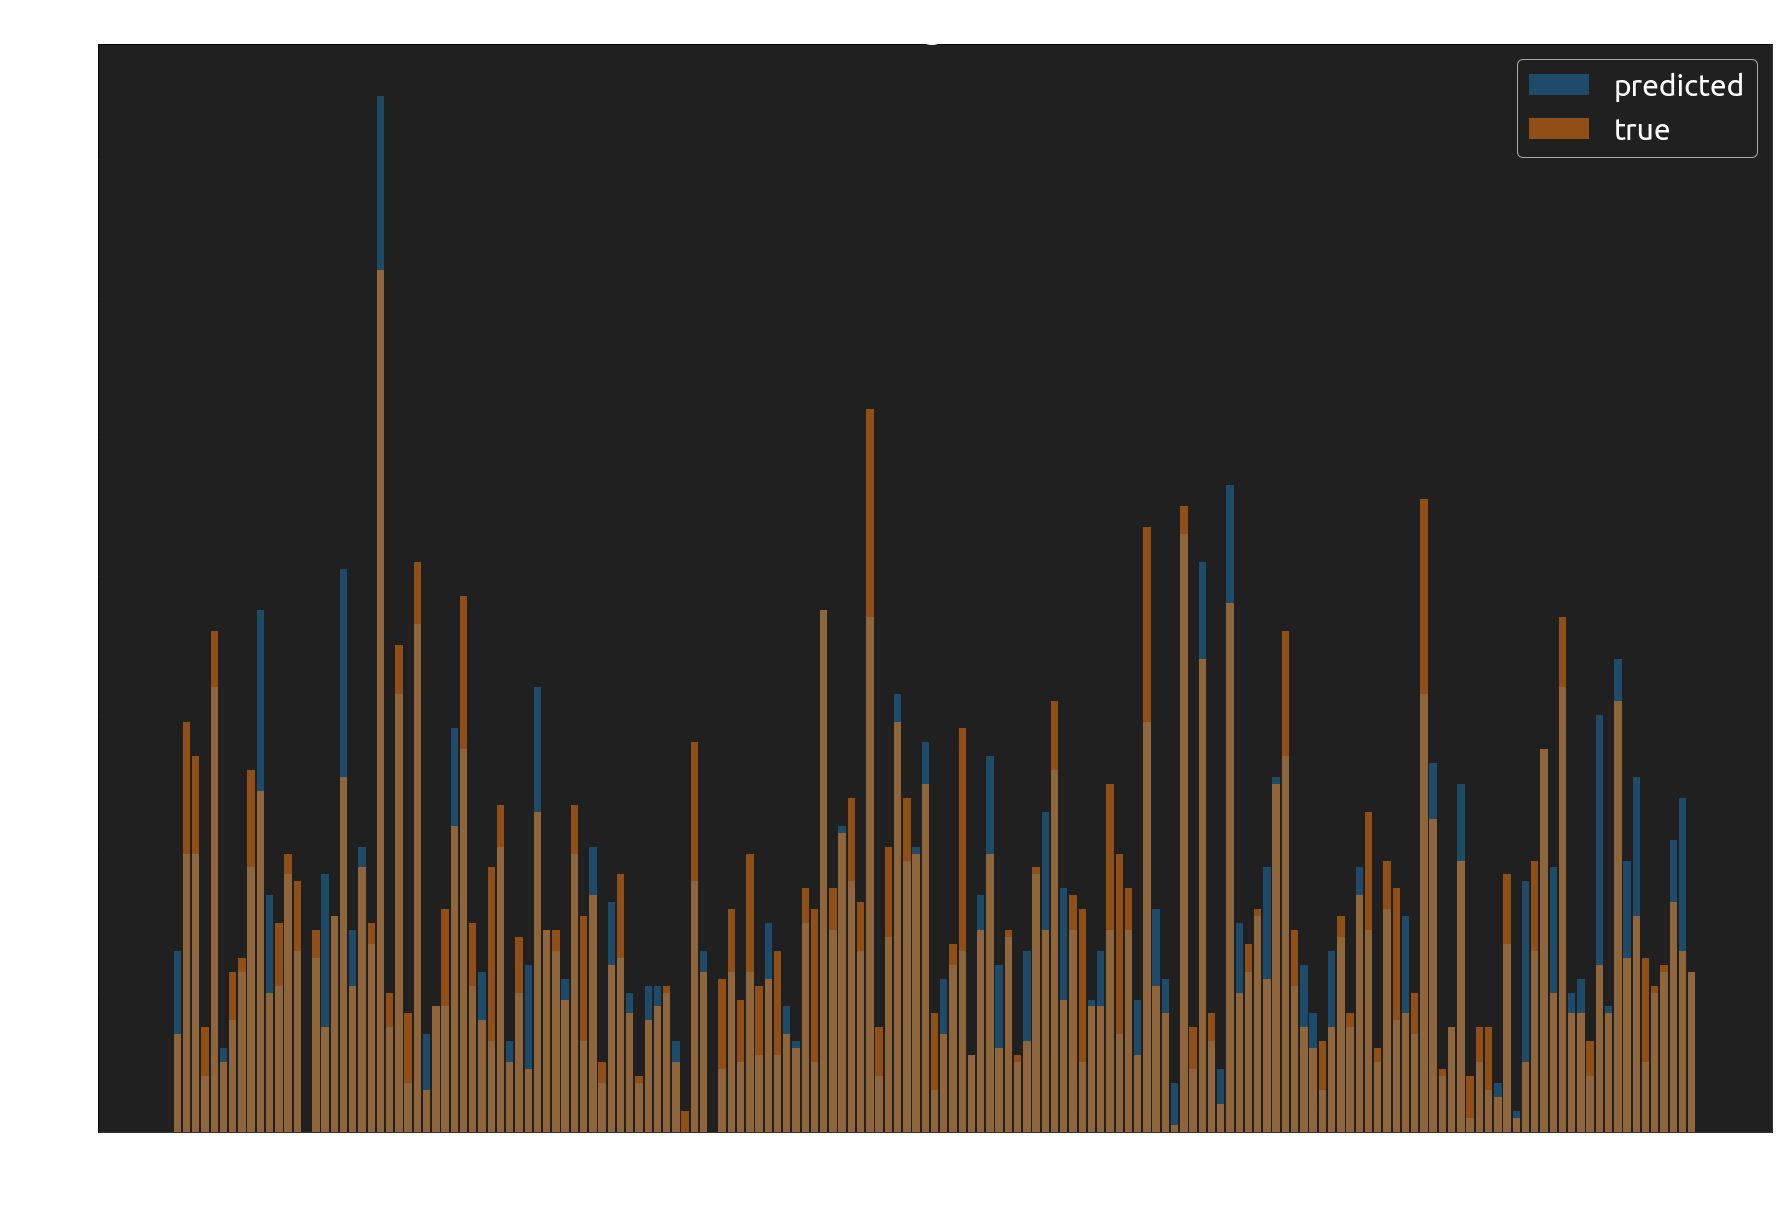

In [163]:
def plot_distribution(df_1, df_2):
    plt.figure(figsize=(30,20))
    n_min = 166
    freq_true = df_1[df_1['ID'] < n_min].groupby(['ID']).size()
    freq_pred = df_2[df_2['ID'] < n_min].groupby(['ID']).size()
    plt.bar(freq_pred.index, freq_pred, label='predicted', alpha=0.5)
    plt.bar(freq_true.index, freq_true, label='true', alpha=0.5)
    plt.title('Neuron Firing Distribution', fontsize=40)
    plt.legend(fontsize=30)
    plt.xlabel('Neuron ID (n)', fontsize=30)
    plt.ylabel('Count (N)', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.show()


plot_distribution(df_true, df_pred)
# plt.savefig("id_interval_dist.png", dpi=300)

In [ ]:
len_pred = len(df_true)
# len_pred = 1000
plt.figure(figsize=(40,40))
plt.title('Pixel / Spike Raster', size=50)
plt.xlabel('Time')
plt.ylabel('Neuron ID')
plt.scatter(test_data['Time'], test_data['ID'], alpha=0.6, label='true', marker='o')
plt.scatter(df_pred['Time'], df_pred['ID'], alpha=0.6, label='predicted', marker='x')
plt.legend(fontsize=50)